<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/ColeHensU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homlessness

# Data

2024 was a bad year for homelessness rates in the United States. According to the department of Housing and Urban Developement, the rates of people experiencing homelessness increased by 18.1 percent in 2024. Homelessness continues to be a neglected issue in the US an it is key to understand the causes of homelessness to look for solutions. I found the data I used for the project from a wide variety of goverment sources including the BLS, the federal reserve, and the HUD. I chose to collect data on variables based on my prior understanding of causes of homelessness and also what was available and quantifyable. For example, I collected binary data on what states allow rent control but decided not to use it because I could not account for the extent to which rent control was implemented on a municiple level.

In [79]:
#import statements
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-5t26c281
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-5t26c281
  Resolved https://github.com/pydata/xarray.git to commit c25215299c02cd36781cf3aa38e8583d1fe14849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [80]:
#uh for unhoused
uh = pd.read_csv('https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/homelessness%20rates.csv')
#remove weird outlier values in small states that I doubt are accurate
uh = uh[uh['homelessness'] <= 900]
uh

,Year,State,Debt,Unemployment,homelessness,RentCost,Population,COLI
0,2024,Alabama,1.40,3.1,6.467692,788,4893186,88.10
1,2024,Alaska,1.50,4.6,35.641923,1153,716025,126.60
2,2024,Arizona,1.84,3.7,19.158042,1064,7174064,105.80
3,2024,Arkansas,1.32,3.3,8.504654,696,3011873,90.60
4,2024,California,1.60,5.4,46.554113,1488,39346023,137.60
...,...,...,...,...,...,...,...,...
199,2021,Virginia,1.84,2.6,6.947180,842,8365985,104.86
200,2021,Washington,1.50,3.9,16.054427,850,7169985,123.78
201,2021,West Virginia,1.32,3.8,6.195439,599,1836835,100.68
202,2021,Wisconsin,1.24,2.9,7.351799,637,5763215,97.51


Year: the data was taken from 2021-2024 because recent data is more available
State: all 50 states plus DC are included in the data set
Debt: debt is debt as a proportion of personal income
Unemployment: unemployment rates in each state
Homelessness: number of unhoused persons per 10,000
rent cost: average cost of rent for a 1 bedroom apartment in the state
Population: estimates of the population for each state
COLI: cost of living index. Measurement of the cost of living in each state relative to each other.

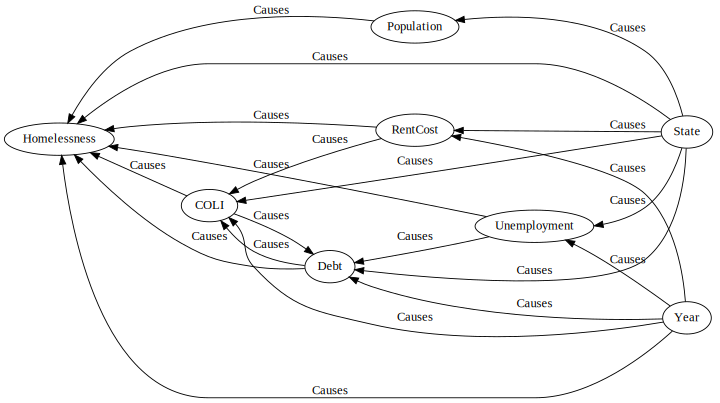

In [81]:
#first i will try to make a casual diagram with arviz
#i looked it up appearently graphviz is what I want to be using
import graphviz
f = graphviz.Digraph('Homelessness dag', filename='hmlns.gv')
f.attr(rankdir='RL', size='10,10')
#f is the graph f.node creates a node in the graph
f.node('Homelessness')
f.node('Population')
f.node('Unemployment')
f.node('RentCost')
f.node('State')
f.node('Year')
f.node('Debt')
f.node('COLI')
#edges are basically the connections between the nodes. The label is set to
#causes because I am showing where I think there are causal relationships.
f.edge('Population', 'Homelessness', label='Causes')
f.edge('Unemployment', 'Homelessness', label='Causes')
f.edge('RentCost', 'Homelessness', label='Causes')
f.edge('Debt','Homelessness', label='Causes')
f.edge('COLI', 'Homelessness', label ='Causes')
f.edge('RentCost', 'COLI', label='Causes')
f.edge('Debt', 'COLI', label='Causes')
f.edge('COLI', 'Debt', label='Causes')
f.edge('Unemployment', 'Debt', label='Causes')
f.edge('Year', 'Homelessness', label='Causes')
f.edge('State', 'Homelessness', label='Causes')
f.edge('State', 'Debt', label='Causes')
f.edge('State', 'Unemployment', label='Causes')
f.edge('State', 'RentCost', label='Causes')
f.edge('State', 'COLI', label='Causes')
f.edge('State', 'Population', label='Causes')
f.edge('Year', 'Debt', label='Causes')
f.edge('Year', 'Unemployment', label='Causes')
f.edge('Year', 'RentCost', label='Causes')
f.edge('Year', 'COLI', label='Causes')
display(f)

Ok. Lots to talk about here. I'm going to start witht he connections to homelessness which is the variable that I am predicting. For starters, all the variable are causes of homelessness, in fact I picked out the variables because I thought they were causes. Population causes homelessness because more people means less land recources per person, unemployment reduces the number of people rich enough to pay rent or buy a house, higher rent costs mean less people can afford rent, higher rates of indebtedness measured as a percentage of income means less money if avaiable for housing. COLI is cost of living index, if it is more expensive to live somewhere, homelessness among unemployed people is going to by higher. Wages are also higher but only if you have a job. I also said debt causes COLI to increase with the rational that servicing debt cost money, however, I don't know whether or not this is measured in the COLI data I am using. Furthermore, there are confounding variables like wages that impact both. The reason I did not include wage value in this data set is that the people at risk for homelessness are not going to be represented in the wage data and in fact higher wages are likely to be associated with higher homelessness because of differences in cost of living and urban populations. State and Year are variables I decided to add later and I said they cause basically all the other variables because the time and place contains a lot of implied information that is relevant to all the other variables.

In [82]:
uh = uh.dropna(how='all')

In [83]:
#I am going to start simple with a model of homelessness with cost of living
#index as a variable. I predict states with a higher cost of living will
# have higher rates of homelessness because the minimum income required to live
# is higher
model_hmln_coli = bmb.Model("homelessness ~ COLI", uh, family="negativebinomial")
idata_hmln_coli = model_hmln_coli.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [84]:
#similarly, urban areas have higher levels of homelessness so I think the model
#will be improved if I account for different population levels. I could have
# used population density instead, but the data for population was easier to come by
# sqrt populaiton because there is likely to be a deminishing impact of
#populaiton on the homelessness rates.
#eg double population will not double #homelessness/10000 people
model_hmln_coli_pop = bmb.Model("homelessness ~ COLI + np.sqrt(Population)", uh, family="negativebinomial")
idata_hmln_coli_pop = model_hmln_coli_pop.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [85]:
# switched out population for unemployment to compare the two
model_hmln_coli_unp = bmb.Model("homelessness ~ COLI + Unemployment", uh, family="negativebinomial")
idata_hmln_coli_unp = model_hmln_coli_unp.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [86]:
#model with all variables except for population. The model throws a fit when I
#include population values, I think this is because the population values are
# very large. My hope is that including a "state" categorical variable will
# have the same impact because there are differences between states in pop
model_hmln = bmb.Model("homelessness ~ Unemployment + RentCost + Debt + COLI + State", uh, family="negativebinomial")
idata_hmln = model_hmln.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [87]:
#this is the same model but without state
model_hmln_ns = bmb.Model("homelessness ~ Unemployment + RentCost + Debt + COLI", uh, family="negativebinomial")
idata_hmln_ns = model_hmln_ns.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

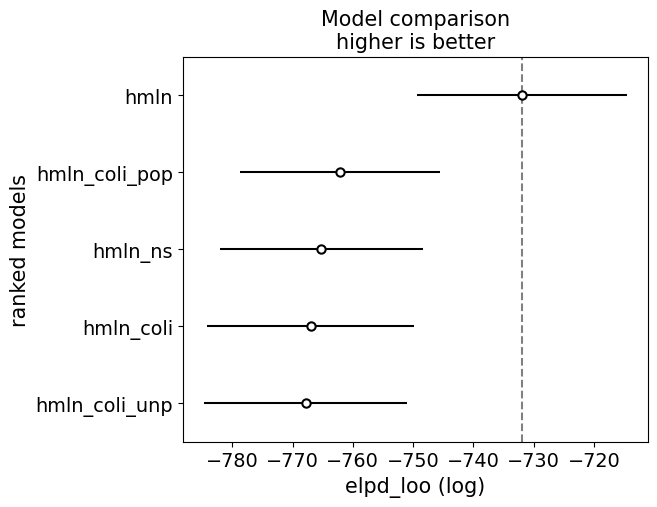

In [88]:
cmp_df = az.compare( {"hmln":idata_hmln,"hmln_ns":idata_hmln_ns, "hmln_coli":idata_hmln_coli, "hmln_coli_pop":idata_hmln_coli_pop,  "hmln_coli_unp":idata_hmln_coli_unp} )
az.plot_compare(cmp_df)

Looking at these elpd_loo values, there is a very big difference when I add the state variable. This aligns with my intuition because the state variable represents a bunch of different variables like social safety nets that doesn't show up anywhere in the data I have.

In [89]:
# now I am going to try removing some of the variables I think are less likely
# to have an impact
# i will start with rentcost data because it should actually be included in the
# coli data
model_hmln_nrc = bmb.Model("homelessness ~ State + Unemployment + Year", uh, family="negativebinomial")
idata_hmln_nrc = model_hmln_nrc.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


I did some fiddling with different variables and I found that State and Unemployment numbers were as good as State, Unemployment and more variables.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

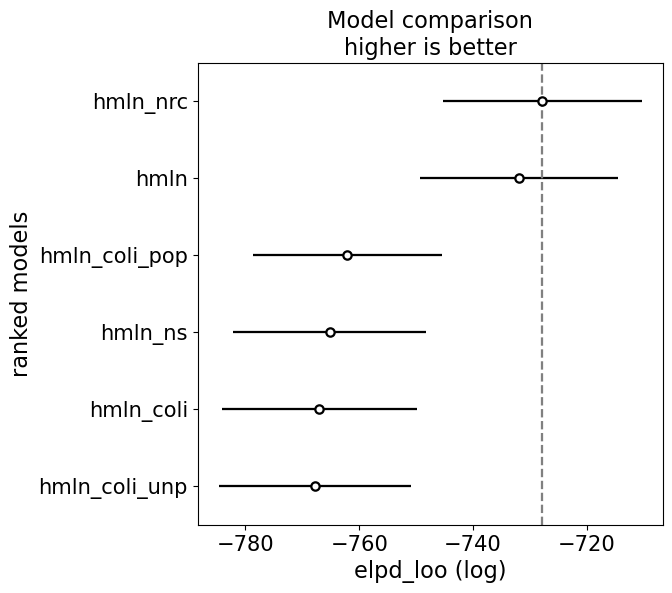

In [90]:
cmp_df = az.compare({"hmln":idata_hmln,"hmln_ns":idata_hmln_ns,
                      "hmln_coli":idata_hmln_coli, "hmln_coli_pop":idata_hmln_coli_pop,
                      "hmln_coli_unp":idata_hmln_coli_unp, "hmln_nrc":idata_hmln_nrc})
az.plot_compare(cmp_df)

So what I have learned from this is essentially that the categorical variable state does the best job of predicting the homelessness rates of all the variables and in fact the other variables don't matter as much. In fact, State and Unemployment seem to be the best variable to use. This checks out with my intuition as well because when people don't have jobs, they can't afford to buy and house and the state you live in has a lot to do with all the other variables. I decided to also add year because while the data I used came from a relatively short time frame of only 4 years, there are also national trends of homelessness that I think the year has an impact on.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


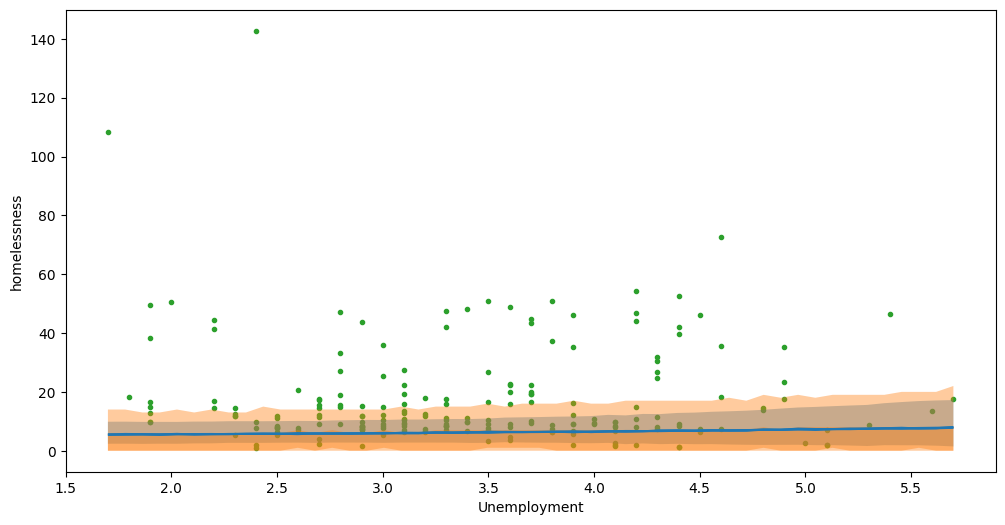

In [91]:
# code from notes
#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_hmln_nrc, idata_hmln_nrc, "Unemployment", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_hmln_nrc, idata_hmln_nrc, "Unemployment", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_hmln_nrc, idata_hmln_nrc, "Unemployment", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(uh.Unemployment, uh.homelessness, "C2.", zorder=-3)

This graph actually shows a very flat chart when comparing unemployment with homelessness, however, I will die on the hill of using unemployment regaurdless. Unemployment definitely causes homelessness, the issue is how unemployment is measured. For example, a homeless person not looking for a job is not considered unemployed by the government because they are not in the workforce. Even this version of unemployment is useful to have in the model because by prior knowledge is that everything else equal, a high number of people looking for jobs and unable to find them results in a high unemployment rate. I suspect the reason we don't see this trend here is that the data is from 4 years only and from 50 very different states that have very different "natural" unemployment levels related to the characteristics of the state economies. The 4 unemployment values for each state are likely very similar; if the data were taken over a longer period of time, I think there would be more of a trend.

That's my project! I learned that the different states are different.